<center><h1>VC05: Agrupamiento basado en densidad - Affinity Propagation</h1></center>

En esta práctica estudiaremos las ideas básicas que hemos visto como introducción al agrupamiento basado en densidad, propagación de afinidad.

Para empezar, cargamos las librerías que vamos a necesitar:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from itertools import cycle


Empezamos creando el conjunto de datos con el que trabajaremos:


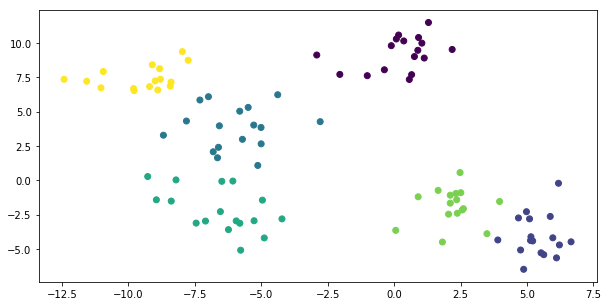

In [2]:
np.random.seed(23) # Fijamos una semilla para asegurar la reproducibilidad de la práctica

Dx, Dy = make_blobs(100, 2, centers=6, cluster_std=1.3)
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0], Dx[:,1], c = Dy)


Como hemos estudiado en la parte teórica, el algoritmo de propagación de afinidad consta de dos pasos: la actualización de la matriz R y la de la matriz A. En el caso de la matriz R, se le resta a la matriz de similitud el valor máximo de la suma de la disponibilidad A y la similitud S entre $x_i$ cualquier otro $x_{k'}$ (para $x_i$ y $x_k$). Aprovecharemos que ese valor siempre es constante para todo $k' \neq k$ y lo calcularemos sólo dos: para todo valor de $k'\neq k$ y para $k$.

Además, en la práctica es habitual usar un factor de aprendizaje. No se sustituye directamente el antiguo valor de R con el nuevo, sino que se hace una media ponderada (según el factor) entre los valores antiguo y nuevo de tal manera que se mantiene un $100\times factor\%$ del antiguo y se incorpora un $100\times (1-factor)\%$ del nuevo valor de R calculado:


In [3]:
def actualizar_matriz_R(mR, mA, mSimilitud, factor = 0.5):
    rows = np.arange(mR.shape[0])

    mAux = mSimilitud + mA
    np.fill_diagonal(mAux, -np.inf)

    # Obtenemos los valores máximos de cada fila
    lIndMaximos = np.argmax(mAux, axis=1)
    maxValor = mAux[rows, lIndMaximos]
    mMax = np.zeros_like(mR) + maxValor[:, None]

    # Obtenemos el segundo valor más alto, para k
    mAux[rows, lIndMaximos] = -np.inf
    maxValorK = mAux[rows, np.argmax(mAux, axis=1)]
    mMax[rows, lIndMaximos] = maxValorK

    return mR * #### TU CODIGO AQUI #### + (mSimilitud - mMax) * #### TU CODIGO AQUI ####


En el caso de la actualización de la matriz A, hay dos casos diferentes: si $i=k$ y si $i\neq k$. 
Básicamente, se suman las responsabilidades positivas de una serie de valores de la matriz.

De igual manera, se suele usar un factor de aprendizajeque pondera entre los valores antiguo y nuevo:


In [4]:
def actualizar_matriz_A(mA, mR, factor = 0.5):
    mA_act = np.array(mR)
    mA_act[mA_act < 0] = 0
    np.fill_diagonal(mA_act, np.diag(mR))
    # se reduce a un vector
    mA_act = mA_act.sum(axis=0)

    # se repite el vector en varias columnas
    mA_act = np.ones(mA.shape) * mA_act
    # se elimina el que no suma (i != i')
    mA_act -= np.clip(mR, 0, np.inf)
    mA_act[mA_act > 0] = 0

    # Calcular valores de la diagonal principal (i=k)
    mD = np.array(mR)
    mD[mD < 0] = 0
    np.fill_diagonal(mD, 0)
    
    np.fill_diagonal(mA_act, np.sum(mD, axis=0))
    
    return mA * #### TU CODIGO AQUI #### + mA_act * #### TU CODIGO AQUI ####


Una vez tenemos las dos funciones de actualización, sólo falta crear el algoritmo que de manera iterativa llama a las dos funciones previas:


In [5]:
def agrupamiento_propagacion_afinidad(mSimilitud, factor = 0.5, n_iteraciones = 200):
    lEtiquetas = []

    mR = np.array(mSimilitud)
    mA = np.array(mSimilitud)

    mFinal_ant = np.zeros(mA.shape)
    
    for i in np.arange(n_iteraciones):
        mR = #### TU CODIGO AQUI ####
        mA = #### TU CODIGO AQUI ####
        mFinal = mA + mR

        lEtiquetas.append( np.argmax(mFinal, axis=1) )

        if np.allclose(mFinal_ant, mFinal):
            break
            
        mFinal_ant = mFinal
        
    return lEtiquetas


Con estas tres funciones ya podemos ejecutar el algoritmo de propagación de afinidad. Sólo necesitamos calcular la matriz de similitud y asignar los valores de preferencia a la diagonal principal de dicha matriz. Un valor habitual para la preferencia suele ser la mediana de la matriz de similitud:


In [6]:
from sklearn.metrics.pairwise import euclidean_distances

mSimilitud = euclidean_distances(Dx)
mSimilitud = -mSimilitud**2

preferencia = #### TU CODIGO AQUI ####
np.fill_diagonal(mSimilitud, preferencia)

factor = 0.5

clustering = agrupamiento_propagacion_afinidad(mSimilitud, factor)


Añadimos una función que nos permite dibujar el proceso de búsqueda de los clústeres del agrupamiento:


In [7]:
def plot_clustering(Dx, Dy):
    fig = plt.figure(figsize=(10, 5))
    centros = np.unique(Dy)
    colores = dict(zip(centros, cycle('bgrcmyk')))

    for i in range(Dy.size):
        plt.plot(Dx[i,0], Dx[i,1], 'o', markersize = 3, c = colores[Dy[i]])
        if i in centros:
            plt.plot(Dx[i,0], Dx[i,1], 'o', markersize = 10, markeredgecolor = 'k', c=colores[i])
        else:
            plt.plot([Dx[i,0], Dx[Dy[i],0]], [Dx[i,1], Dx[Dy[i],1]], c=colores[Dy[i]])
    plt.title('Núm. clústeres: %s' % centros.size)


Y lo mostramos:


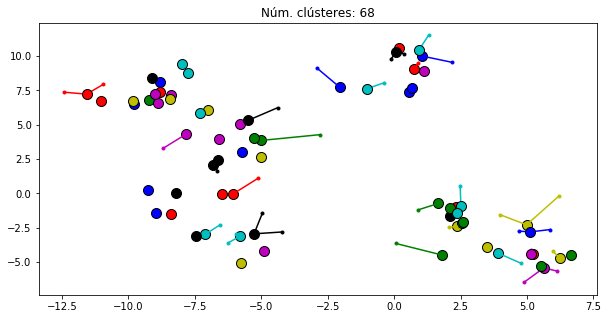

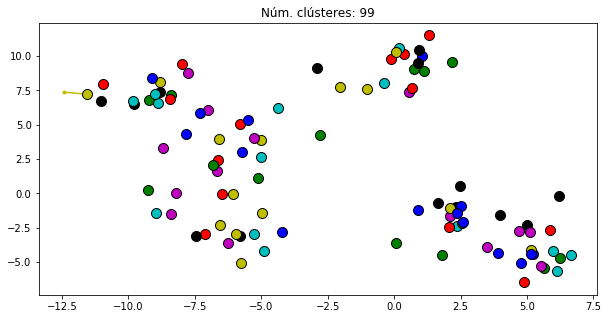

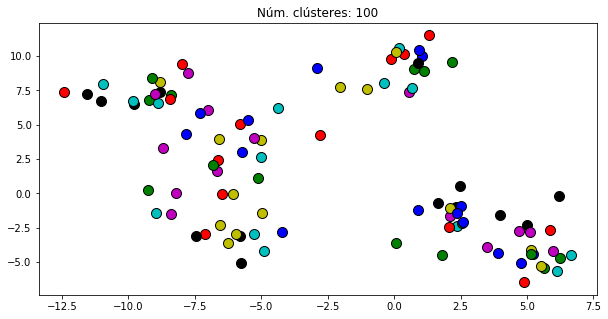

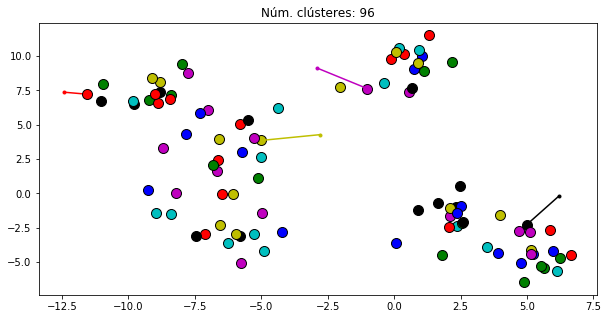

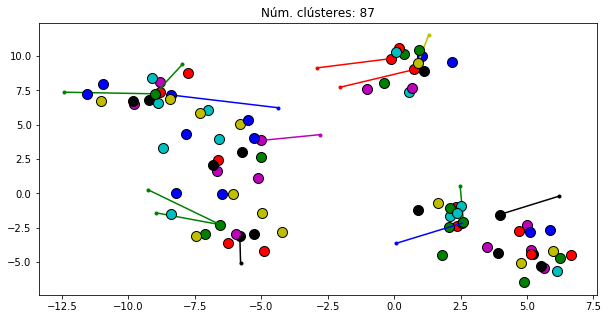

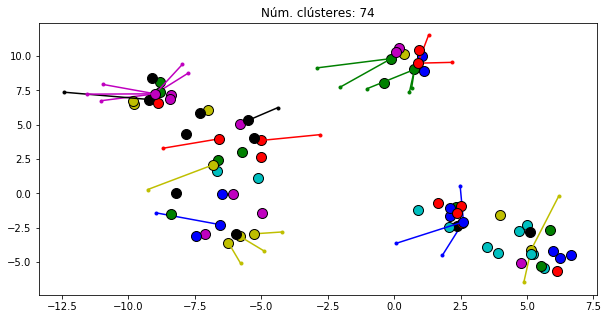

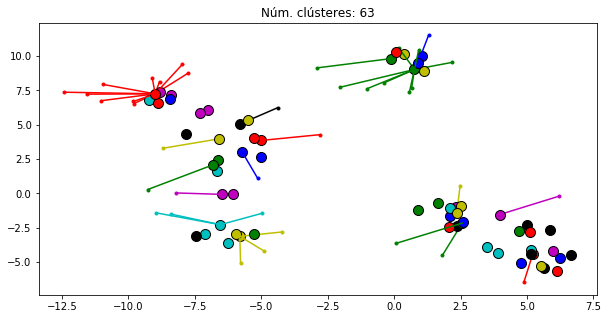

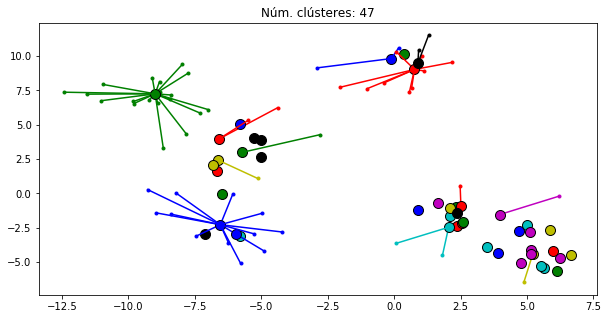

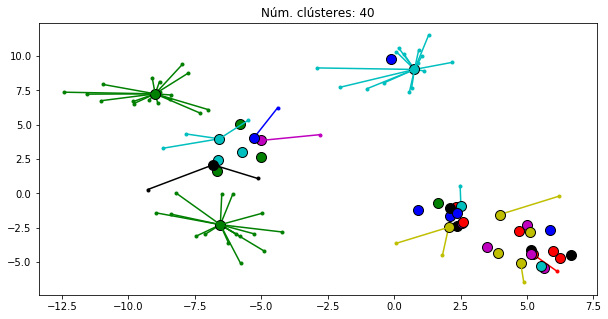

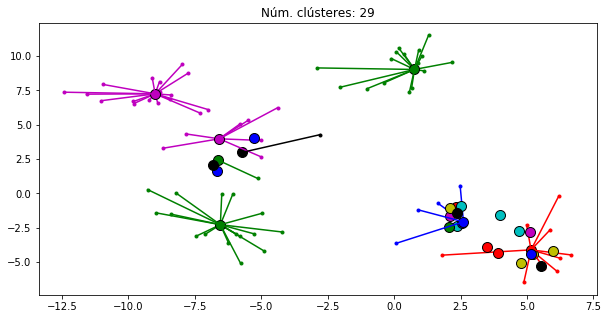

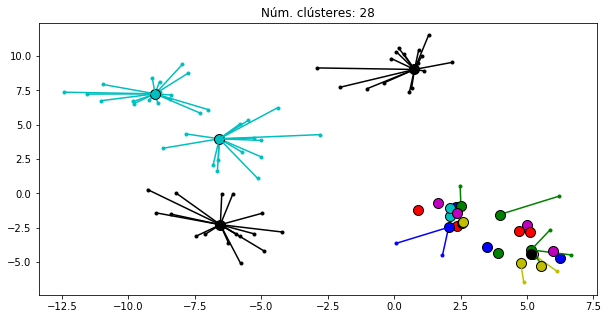

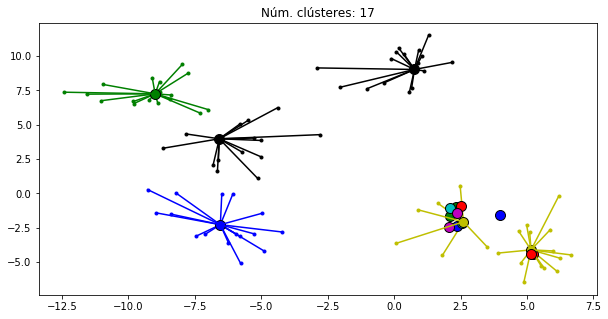

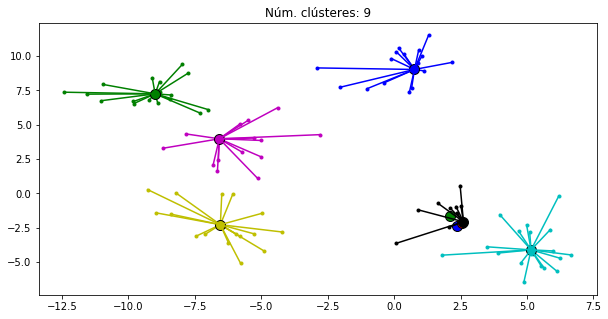

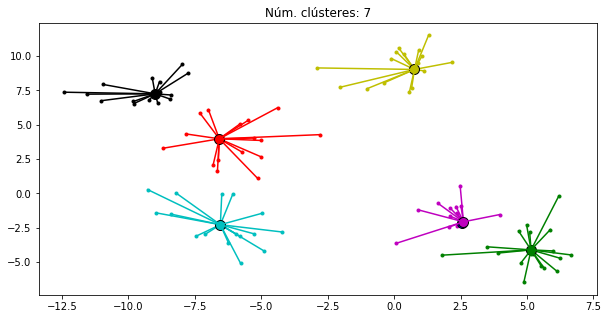

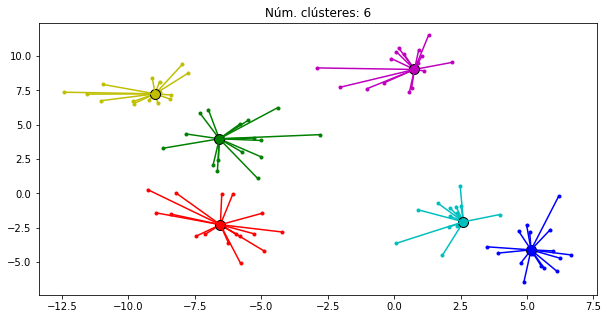

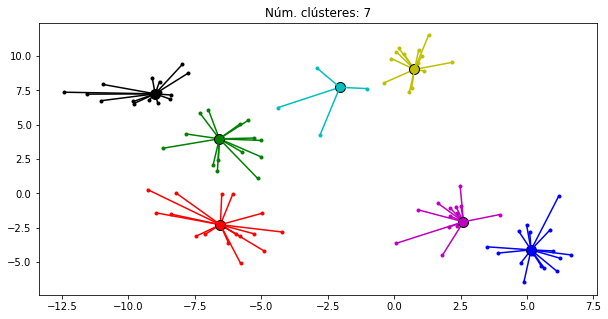

In [8]:
centros_ant = np.array([])

for i in np.arange(len(clustering)):
    centros = np.unique(clustering[i])

    if centros_ant.size != centros.size or np.all(centros_ant != centros):
        plot_clustering(Dx, clustering[i])

    centros_ant = centros


También se puede estudiar la bondad de la agrupación conociendo la realidad:


In [9]:
def matriz_confusion(cat_real, cat_pred):
    cats = np.unique(cat_real)
    clusts = np.unique(cat_pred)
    mat = np.array([[np.sum(np.logical_and(cat_real==cats[i], cat_pred==clusts[j])) 
                     for j in np.arange(clusts.size)] 
                    for i in np.arange(cats.size)])
    return(mat)

def medida_error(mat):
    assign = np.sum([np.max(mat[l,:]) for l in np.arange(mat.shape[0])])
    return 1 - assign / float(np.sum(mat))

def medida_pureza(mat):
    totales = np.sum(mat,0)/float(np.sum(mat))
    return np.sum([totales[k] * np.max(mat[:,k]/float(np.sum(mat[:,k]))) for k in np.arange(mat.shape[1])])

def medida_precision(mat, l, k):
    return mat[l,k]/float(np.sum(mat[:,k]))

def medida_recall(mat, l, k):
    return mat[l,k]/float(np.sum(mat[l,:]))

def medida_f1_especifica(mat, l, k):
    prec = medida_precision(mat, l, k)
    rec = medida_recall(mat, l, k)
    if (prec+rec)==0:
        return 0
    else:
        return 2*prec*rec/(prec+rec)

def medida_f1(mat):
    totales = np.sum(mat,1)/float(np.sum(mat))
    assign = np.sum([totales[l] * np.max([medida_f1_especifica(mat, l, k) 
                                          for k in np.arange(mat.shape[1])]) 
                     for l in np.arange(mat.shape[0])])
    return assign

Dyp = clustering[len(clustering)-1]
mC = matriz_confusion(Dy,Dyp)

print(mC)
print('El valor del error cometido es = ', medida_error(mC))
print('La pureza del agrupamiento obtenido es = ', medida_pureza(mC))
print('El valor F1 es = ', medida_f1(mC),
      ' (** ESTE ES EL RESULTADO A INCLUIR EN EL CAMPUS**)')

[[ 0  0  0  2  0 15  0]
 [17  0  0  0  0  0  0]
 [ 0 15  0  2  0  0  0]
 [ 0  0 17  0  0  0  0]
 [ 1  0  0  0 15  0  0]
 [ 0  0  0  0  0  0 16]]
El valor del error cometido es =  0.050000000000000044
La pureza del agrupamiento obtenido es =  0.9700000000000001
El valor F1 es =  0.9687315668202766


<hr>
<h2>Implementaciones en librerías de Python</h2>

La librería ScikitLearn ya implementa el algoritmo de clustering AffinityPropagation.

In [10]:
from sklearn.cluster import AffinityPropagation

clustering = AffinityPropagation(preference=preferencia, damping=factor).fit(Dx)


Creamos primero una función para dibujar el resultado:


In [11]:
def dibujar_clusteringAP(modelo):
    fig = plt.figure(figsize=(10, 5))

    ncentros = modelo.cluster_centers_indices_.size
    colores = 'bgrcmyk'

    for k in np.arange(ncentros):
        kc = k % len(colores)

        centro = Dx[modelo.cluster_centers_indices_[k],:]
        miembros_cluster = np.where(modelo.labels_ == k)[0]

        plt.scatter(Dx[miembros_cluster, 0], Dx[miembros_cluster, 1], c=colores[kc], s=3)
        for i in miembros_cluster:
            plt.plot([centro[0], Dx[i,0]], [centro[1], Dx[i,1]], c = colores[kc])

    plt.scatter(Dx[modelo.cluster_centers_indices_,0], Dx[modelo.cluster_centers_indices_,1], 
                s=50, c = 'black')

    plt.title('Núm. clústeres: %s' % ncentros)
    plt.show()


Podemos hacer pruebas con diferentes datasets y valores de preferencia:


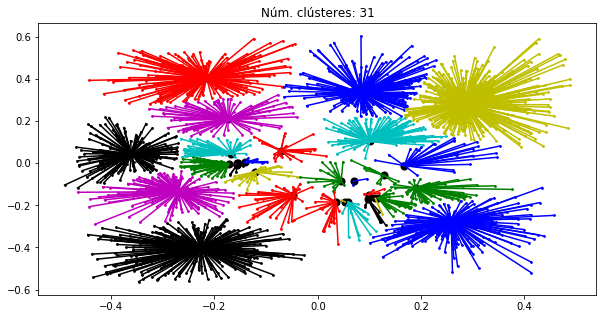

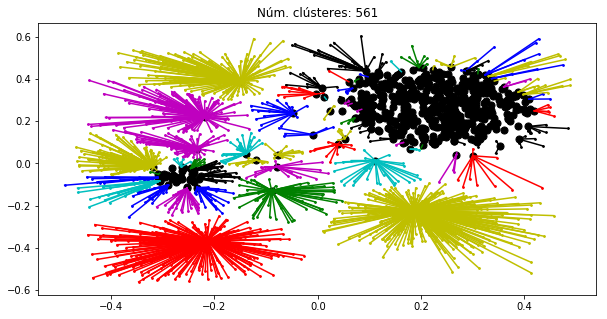

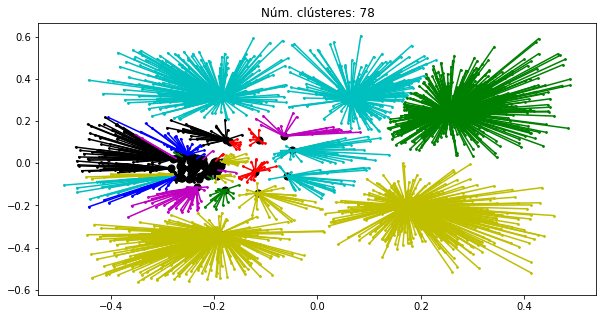

In [12]:
data_file_url = 'https://raw.githubusercontent.com/jhernandezgonzalez/unsupervisedlearning/master/datasets/sinteticos/dataset_inseparable.csv'
#data_file_url = 'https://raw.githubusercontent.com/jhernandezgonzalez/unsupervisedlearning/master/datasets/sinteticos/dataset_dos_remolinos.csv'
#data_file_url = 'https://raw.githubusercontent.com/jhernandezgonzalez/unsupervisedlearning/master/datasets/sinteticos/dataset_cuatro_diferente_medida.csv'
D = np.array(pd.read_csv(data_file_url,header=0))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:2]
Dy = D[:,2]

factor = 0.5

mSimilitud = euclidean_distances(Dx)
mSimilitud = -mSimilitud**2

preferencia = np.median(mSimilitud, axis=1)*10
np.fill_diagonal(mSimilitud, preferencia)

Dyp1 = AffinityPropagation(preference=preferencia).fit(Dx)
dibujar_clusteringAP(Dyp1)


preferencia = np.median(mSimilitud, axis=1)*30
np.fill_diagonal(mSimilitud, preferencia)

Dyp1 = AffinityPropagation(preference=preferencia).fit(Dx)
dibujar_clusteringAP(Dyp1)


preferencia = np.median(mSimilitud, axis=1)*50
np.fill_diagonal(mSimilitud, preferencia)

Dyp1 = AffinityPropagation(preference=preferencia).fit(Dx)
dibujar_clusteringAP(Dyp1)
